### https://kaggle.com/competitions/flight-delays-spring-2018

Датасет содержит данные о полетах гражданской авиации в США в 2018 г.\
Таргет - задержан ли вылет самолета на 15 минут и более (да/нет)

__Бизнес-задача__: реализовать классификатор, предсказывающий задержку самолета. \
__Зачем__ : с его помощью аэропорты могут точнее планировать расписание полетов и работу персонала, пассажиры смогут тщательнее планировать свои путешествия, а авиалинии - устранять недочеты с помощью интерпретации признаков, избегать лишних штрафов и простоев авиапарка.

__ML-задача__: Бинарная классификация

__Метрика: F-score__\
На первый взгляд не очевидно, критичнее здесь False Positive или False Negative ошибка. Но мое предположение состоит в том, что максимизировать Recall более целесообразно, нежели Precision. Авиалиниям проще предупредить, что рейс задержится, и тогда остальные участники (пассажиры и аэропорты) будут строить из этого факта свои ожидания и планы. Также авиалинии снижают риски возможных претензий, судов и штрафов. Однако не совсем понятно, насколько "дорого" обойдется такое суждение для авиакомпании : она может закладывать задержку рейса в свою деятельность, но самолеты будут прилетать вовремя и простаивать (а это звучит дорого в плане содержания самолета и экипажа), если мы лишний раз предскажем задержку вылета, будучи действующим сервисом в рамках авиалинии. Поэтому я остановлю свой выбор на F-score, который покрывает обе этих метрики.

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [158]:
df = pd.read_csv('flight_delays_train.csv')

In [159]:
df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


__В наборе данных содержатся поля:__
* Месяц рейса
* День месяца 
* День недели 
* Время вылета
* Название авиалинии
* Аэропорт отправления
* Аэропорт назначения
* Расстояние между аэропортами
* Факт задержки рейса более, чем на 15 минут

In [160]:
# Заменим даты на соотв. порядковые числа

In [161]:
df['Month'] = df['Month'].str.replace("c-","")
df['DayofMonth'] = df['DayofMonth'].str.replace("c-","")
df['DayOfWeek'] = df['DayOfWeek'].str.replace("c-","")

df['Month'] = df['Month'].astype(int)
df['DayofMonth'] = df['DayofMonth'].astype(int)
df['DayOfWeek'] = df['DayOfWeek'].astype(int)

In [162]:
df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,N
99996,1,18,3,804,CO,EWR,DAB,884,N
99997,1,24,2,1901,NW,DTW,IAH,1076,N
99998,4,27,4,1515,MQ,DFW,GGG,140,N


In [163]:
df.describe()

,Month,DayofMonth,DayOfWeek,DepTime,Distance
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000
mean,6.537640,15.703850,3.95183,1341.523880,729.39716
std,3.413447,8.793931,1.99164,476.378445,574.61686
min,1.000000,1.000000,1.00000,1.000000,30.00000
25%,4.000000,8.000000,2.00000,931.000000,317.00000
50%,7.000000,16.000000,4.00000,1330.000000,575.00000
75%,9.000000,23.000000,6.00000,1733.000000,957.00000
max,12.000000,31.000000,7.00000,2534.000000,4962.00000


In [164]:
df.isna().sum()

Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
UniqueCarrier        0
Origin               0
Dest                 0
Distance             0
dep_delayed_15min    0
dtype: int64

In [165]:
#катег. признаки
cat_features = ['Month', 'DayofMonth','DayOfWeek','UniqueCarrier','Origin','Dest']
for feat in df[cat_features]:
    print(feat, 'has unique values', len(np.unique(df[feat])))
#DepTime можно разбить на отдельные признаки "час" и "минуты",но можно и рассматривать как численный признак

Month has unique values 12
DayofMonth has unique values 31
DayOfWeek has unique values 7
UniqueCarrier has unique values 22
Origin has unique values 289
Dest has unique values 289


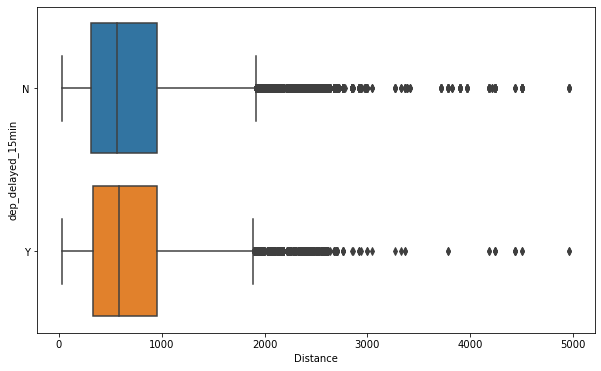

In [166]:
# Преобладают относительно короткие перелеты (примерно 700 км)
# Нет явной зависимости от расстояния, значит надо копать в другие признаки



plt.figure(figsize=(10,6))
sns.boxplot(x=df["Distance"], y=df["dep_delayed_15min"]);

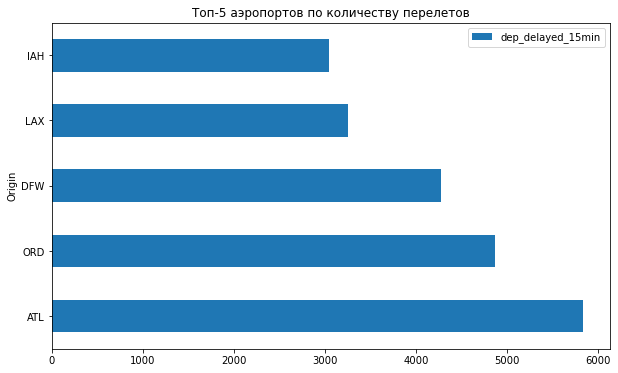

In [167]:
df.groupby('Origin').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).head(5).plot(kind = 'barh', figsize= (10,6))
plt.title('Топ-5 аэропортов по количеству перелетов')
plt.show()

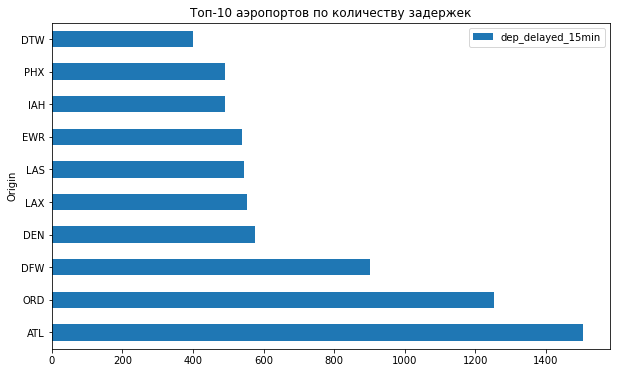

In [168]:
df[df['dep_delayed_15min']=='Y'].groupby('Origin').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).head(10).plot(kind = 'barh', figsize= (10,6))
plt.title('Топ-10 аэропортов по количеству задержек')
plt.show()

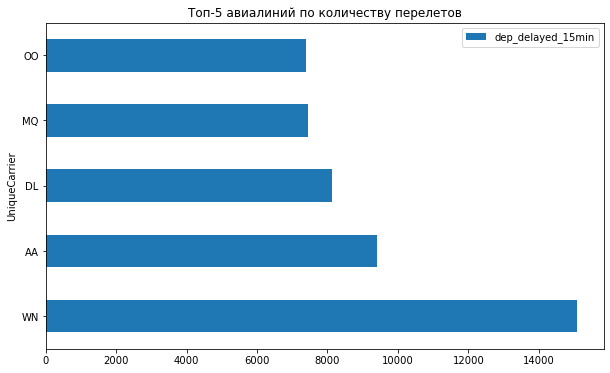

In [169]:
df.groupby('UniqueCarrier').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).head(5).plot(kind = 'barh', figsize= (10,6))
plt.title('Топ-5 авиалиний по количеству перелетов')
plt.show()

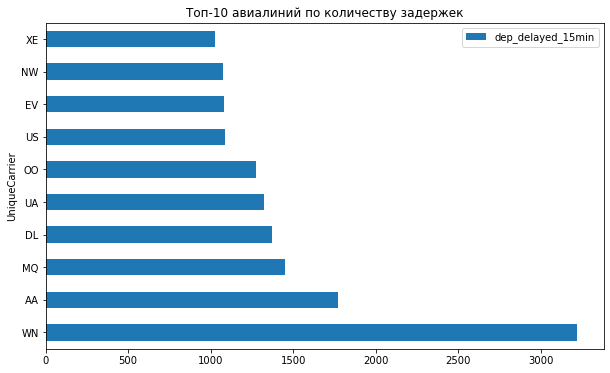

In [170]:
df[df['dep_delayed_15min']=='Y'].groupby('UniqueCarrier').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).head(10).plot(kind = 'barh', figsize= (10,6))
plt.title('Топ-10 авиалиний по количеству задержек')
plt.show()

### Наталкивает на мысль о том, что нужно считать долю задержек, а не абсолютное кол-во, потому что крупнейший аэропорт (или авиакомпания) обслуживает попросту больше перелетов

In [173]:

bad_carriers = pd.merge( \
    df[df['dep_delayed_15min']=='Y'].groupby('UniqueCarrier').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).reset_index(), \
         df.groupby('UniqueCarrier').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).reset_index(), on = 'UniqueCarrier' \
        )


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


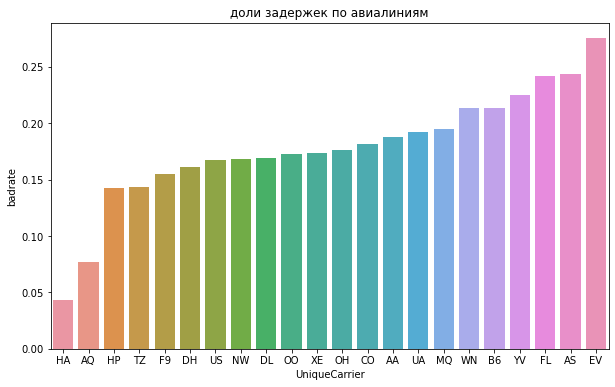

In [174]:
bad_carriers['badrate'] = bad_carriers['dep_delayed_15min_x'] / bad_carriers['dep_delayed_15min_y']
plt.figure(figsize = (10,6))
sns.barplot(bad_carriers['UniqueCarrier'],bad_carriers['badrate'], order = bad_carriers.sort_values(by='badrate').UniqueCarrier)
plt.title('доли задержек по авиалиниям');

In [175]:
bad_carriers.sort_values(by='badrate')

,UniqueCarrier,dep_delayed_15min_x,dep_delayed_15min_y,badrate
20,HA,33,762,0.043307
21,AQ,18,234,0.076923
16,HP,196,1378,0.142235
19,TZ,64,446,0.143498
17,F9,156,1006,0.155070
18,DH,156,966,0.161491
6,US,1085,6482,0.167387
8,NW,1075,6403,0.167890
3,DL,1373,8128,0.168922
5,OO,1277,7390,0.172801


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


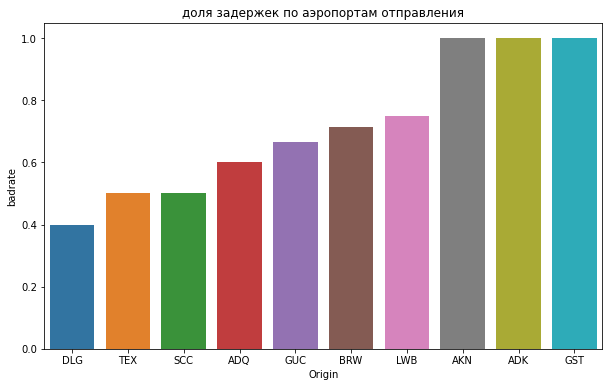

In [176]:
bad_origins = pd.merge( \
    df[df['dep_delayed_15min']=='Y'].groupby('Origin').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).reset_index(), \
         df.groupby('Origin').agg({'dep_delayed_15min':'count'}).\
sort_values(by = 'dep_delayed_15min', ascending = False).reset_index(), on = 'Origin' \
        )

bad_origins['badrate'] = bad_origins['dep_delayed_15min_x'] / bad_origins['dep_delayed_15min_y']

bad_origins = bad_origins.sort_values(by='badrate',ascending = False).head(10)

plt.figure(figsize = (10,6))
sns.barplot(bad_origins['Origin'],bad_origins['badrate'], order = bad_origins.sort_values(by='badrate').Origin)
plt.title('доля задержек по аэропортам отправления');

In [177]:
#Не напрашивается вывод о том, что крупнейшие аэропорты и авиалинии имеют бОльшие доли задержек

In [178]:
# есть ли зависимость задержек от месяца?
bad_month = df[df['dep_delayed_15min']=='Y'].groupby('Month').agg({'dep_delayed_15min':'count'}).reset_index()
bad_month

,Month,dep_delayed_15min
0,1,1539
1,2,1316
2,3,1676
3,4,1306
4,5,1313
5,6,1867
6,7,2073
7,8,1783
8,9,1279
9,10,1501


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


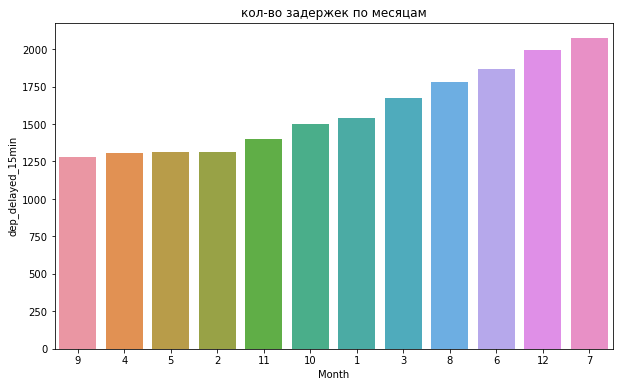

In [179]:
plt.figure(figsize = (10,6))
sns.barplot(bad_month['Month'],bad_month['dep_delayed_15min'], order = bad_month.sort_values(by='dep_delayed_15min').Month)
plt.title('кол-во задержек по месяцам');

#видно, что в рамках этого датасета в июне, июле, декабре задержки чаще всего

In [180]:
# есть ли зависимость задержек от дня недели?
bad_dweek= df[df['dep_delayed_15min']=='Y'].groupby('DayOfWeek').agg({'dep_delayed_15min':'count'}).reset_index()
bad_dweek

,DayOfWeek,dep_delayed_15min
0,1,2774
1,2,2451
2,3,2567
3,4,3117
4,5,3285
5,6,2145
6,7,2705


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


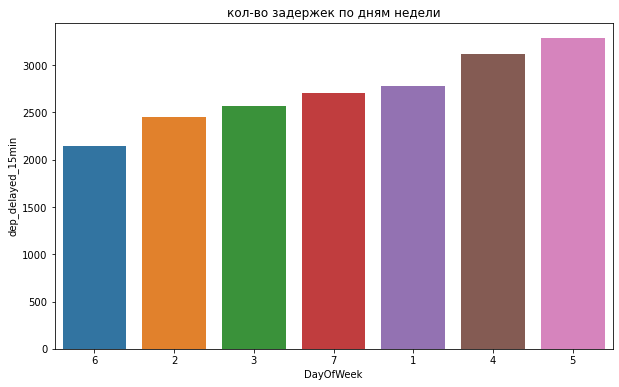

In [181]:
plt.figure(figsize = (10,6))
sns.barplot(bad_dweek['DayOfWeek'],bad_dweek['dep_delayed_15min'], order = bad_dweek.sort_values(by='dep_delayed_15min').DayOfWeek)
plt.title('кол-во задержек по дням недели');

#в этих данных задержки чаще всего по пятницам и четвергам

* кажется, что данных достаточно (10 тыс. наблюдений), чтобы была возможность обучить модель и проверить кач-во
* не совсем очевидно, какие проблемы могут возникнуть в ходе анализа по этим данным
* возможно, для полного анализа еще интересны бы были бинарные переменные о погоде (летная - нелетная)
* пропусков нет


## ДЗ 2

В кач-ве бейзлайна для задачи классификации выберу логистическую регрессию из sklearn

In [182]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

"Календарные" признаки уже изменены \
DepTime и Distance оставлю численными признаками (хотя, наверное, можно предположить, что в пределах суток варианты "Час-минута" значений конечны, как и расстояние внутри одной страны, т.к. перелеты внутренние - известна площадь страны, чтобы рассматривать упомянутые признаки, как категориальные) -> для планируемого бейзлайна-линейной модели нужно отмасштабировать, чтобы модель "могла" обучаться на признаках в одной шкале измеримости.\
Также нужно заменить таргеты на 0 и 1

In [183]:
df['dep_delayed_15min'].replace({'Y':1, 'N':0},inplace = True)

In [184]:
df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,0
1,4,20,3,1548,US,PIT,MCO,834,0
2,9,2,5,1422,XE,RDU,CLE,416,0
3,11,25,6,1015,OO,DEN,MEM,872,0
4,10,7,6,1828,WN,MDW,OMA,423,1
...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,0
99996,1,18,3,804,CO,EWR,DAB,884,0
99997,1,24,2,1901,NW,DTW,IAH,1076,0
99998,4,27,4,1515,MQ,DFW,GGG,140,0


In [185]:
num_feats = ['DepTime', 'Distance']

In [186]:
X = df.drop(['dep_delayed_15min'],axis = 1)
y = df['dep_delayed_15min']

In [187]:
#one hot encoding for cat feats
X = pd.get_dummies(X[cat_features])
X

,Month,DayofMonth,DayOfWeek,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DH,UniqueCarrier_DL,...,Dest_TYS,Dest_VCT,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YUM
0,8,21,7,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,20,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,25,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,7,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,4,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,1,18,3,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
99997,1,24,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99998,4,27,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


OHE выбран, потому что нужно "просто перевести категории в числа", а labelencoder, насколько мне известно, предпочтителен, когда есть какая-либо явная порядковая зависимость (напр. разбалловка A-F в европейской системе обучения). В случае аэропортов и авиакомпаний - это не так. Простыми словами: никаких явных зависимостей между категориями у нас нет.

In [188]:
X = pd.concat([X, df[num_feats]], axis = 1)
X

,Month,DayofMonth,DayOfWeek,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DH,UniqueCarrier_DL,...,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YUM,DepTime,Distance
0,8,21,7,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1934,732
1,4,20,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1548,834
2,9,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1422,416
3,11,25,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1015,872
4,10,7,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1828,423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,4,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1618,199
99996,1,18,3,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,804,884
99997,1,24,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1901,1076
99998,4,27,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1515,140


In [189]:
scaler = StandardScaler()

In [190]:
# стратифицируем выборку, поскольку видно, что присутствует дисбаланс классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [191]:
#самый частый класс 0
y.value_counts()

0    80956
1    19044
Name: dep_delayed_15min, dtype: int64

In [192]:
#константное предсказание абсолютно никакое по качеству 
f1_score(y_test.replace({1:0}), y_test)

0.0

In [193]:
X_train[num_feats] = scaler.fit_transform(X_train[num_feats])
#X_train

In [194]:
X_test[num_feats] = scaler.transform(X_test[num_feats])
#X_test

In [195]:
#поменял solver, т.к. дефолтный оптимизатор выдавал ошибку о несходимости
baseline = LogisticRegression(solver='newton-cg', random_state = 42)

In [196]:
baseline.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='newton-cg')

In [197]:
f1_score(y_test, baseline.predict(X_test))

0.07639569049951028

Полученное качество выглядит не очень хорошим. Кажется, что выбранный бейзлайн - линейная зависимость плохо подходит для наших данных. Благо, что в следующем ДЗ нужно взять модель "сложнее" :)

### ДЗ 3


Более сложная модель - градиентный бустинг от catboost

Поскольку бустинг на деревьях не чувствителен к масштабу данных, а категориальные фичи кодирует самостоятельно, то верну исходный датафрейм в первоначальное состояние.

In [198]:
from catboost import CatBoostClassifier

In [199]:
catboost_X = df.drop(['dep_delayed_15min'],axis = 1)
catboost_y = df['dep_delayed_15min']

In [200]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = \
train_test_split(catboost_X, catboost_y, test_size=0.2, random_state=42, stratify = y)

In [201]:
cboost_base = CatBoostClassifier(random_state = 42)

In [202]:
cboost_base.fit(X_train_cb, y_train_cb, cat_features = cat_features)

Learning rate set to 0.06692
0:	learn: 0.6574718	total: 36.2ms	remaining: 36.2s
1:	learn: 0.6289712	total: 50.6ms	remaining: 25.3s
2:	learn: 0.6054019	total: 62.3ms	remaining: 20.7s
3:	learn: 0.5834025	total: 79ms	remaining: 19.7s
4:	learn: 0.5656418	total: 93ms	remaining: 18.5s
5:	learn: 0.5515791	total: 103ms	remaining: 17.1s
6:	learn: 0.5378910	total: 114ms	remaining: 16.2s
7:	learn: 0.5262139	total: 134ms	remaining: 16.6s
8:	learn: 0.5164094	total: 144ms	remaining: 15.8s
9:	learn: 0.5082619	total: 159ms	remaining: 15.7s
10:	learn: 0.5012053	total: 168ms	remaining: 15.1s
11:	learn: 0.4963157	total: 175ms	remaining: 14.4s
12:	learn: 0.4900522	total: 201ms	remaining: 15.3s
13:	learn: 0.4836090	total: 225ms	remaining: 15.8s
14:	learn: 0.4794649	total: 239ms	remaining: 15.7s
15:	learn: 0.4760549	total: 253ms	remaining: 15.6s
16:	learn: 0.4723928	total: 271ms	remaining: 15.7s
17:	learn: 0.4687387	total: 290ms	remaining: 15.8s
18:	learn: 0.4652690	total: 311ms	remaining: 16s
19:	learn: 0.

In [203]:
f1_score(y_test_cb, cboost_base.predict(X_test_cb))

0.2919738782388877

Бейзлайн на катбусе дал результат гораздо лучше

In [204]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [205]:
grid_cboost_clf = CatBoostClassifier()

Learning rate - узнать, влияет ли скорость сходимости (больше LR - быстрее обучение) на итоговое кач-во\
depth - узнать, влияет ли сложность композиции деревьев на итоговое кач-во (больше depth - дольше обучение)\
l2_leaf - узнать, как сильно нужно "штрафовать" модель за переобучение

In [206]:
learning_rate_values =  [0.03, 0.1]
depth_values =  [4, 6, 10]
l2_leaf_reg_values = [1, 3, 5, 7, 9]

best_score = 0  
best_params = {}  
 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [207]:
cat_features

['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']

Спойлер к перебору параметров на кросс-валидации : локальное устройство помирает при таком переборе, поэтому в какой-то момент пришлось просто остановить перебор параметров. Либо просто блок кода фризится, потому что параметры я смог достать потом.

In [129]:

tuning_progress = []

for l2_leaf_reg in l2_leaf_reg_values:
    for depth in depth_values:
        for learning_rate in learning_rate_values:
            
            model = CatBoostClassifier(l2_leaf_reg=l2_leaf_reg, depth=depth,
                                       learning_rate=learning_rate, cat_features=cat_features, random_state = 42, 
                                       verbose=False)
 
            
            f1_scores = []
            for train_index, val_index in cv.split(X_train_cb, y_train_cb):
                X_train, X_val = X_train_cb.iloc[train_index], X_train_cb.iloc[val_index]
                y_train, y_val = y_train_cb.iloc[train_index], y_train_cb.iloc[val_index]
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                f1 = f1_score(y_val, y_pred)
                f1_scores.append(f1)
 
            mean_f1 = sum(f1_scores) / len(f1_scores)
 
            
            if mean_f1 > best_score:
                best_score = mean_f1
                best_params = {
                    'l2_leaf_reg': l2_leaf_reg,
                    'depth': depth,
                    'learning_rate': learning_rate
                }
 
            
            tuning_progress.append({
                'l2_leaf_reg': l2_leaf_reg,
                'Depth': depth,
                'Learning Rate': learning_rate,
                'F1 Score': mean_f1
            })

KeyboardInterrupt: 

In [130]:
# при этом улучшение кажется неоправданным по затраченныму времени на запуск (на локальном устр-ве)
print(best_score)
print(best_params)

0.29962904157885284
{'l2_leaf_reg': 5, 'depth': 10, 'learning_rate': 0.1}


In [208]:
cboost_best = CatBoostClassifier(depth = 10, learning_rate = 0.1, l2_leaf_reg = 5)

In [209]:
cboost_best.fit(X_train_cb, y_train_cb, cat_features = cat_features)

0:	learn: 0.6422124	total: 14.9ms	remaining: 14.9s
1:	learn: 0.6044886	total: 24.7ms	remaining: 12.3s
2:	learn: 0.5734714	total: 39ms	remaining: 13s
3:	learn: 0.5471904	total: 62.5ms	remaining: 15.6s
4:	learn: 0.5264475	total: 82.3ms	remaining: 16.4s
5:	learn: 0.5117752	total: 98.7ms	remaining: 16.3s
6:	learn: 0.5002823	total: 116ms	remaining: 16.4s
7:	learn: 0.4883491	total: 167ms	remaining: 20.7s
8:	learn: 0.4825718	total: 175ms	remaining: 19.3s
9:	learn: 0.4751274	total: 195ms	remaining: 19.3s
10:	learn: 0.4678232	total: 252ms	remaining: 22.7s
11:	learn: 0.4644823	total: 265ms	remaining: 21.8s
12:	learn: 0.4592394	total: 321ms	remaining: 24.4s
13:	learn: 0.4545048	total: 372ms	remaining: 26.2s
14:	learn: 0.4503408	total: 428ms	remaining: 28.1s
15:	learn: 0.4463690	total: 480ms	remaining: 29.5s
16:	learn: 0.4436312	total: 529ms	remaining: 30.6s
17:	learn: 0.4409697	total: 583ms	remaining: 31.8s
18:	learn: 0.4390636	total: 631ms	remaining: 32.6s
19:	learn: 0.4375303	total: 681ms	remai

In [210]:
# улучшение на 0.02 
f1_score(y_test_cb, cboost_best.predict(X_test_cb))

0.3168476075593084

In [211]:
#!pip install shap

In [212]:
import shap

In [213]:
cboost_best.get_feature_importance(prettified = True)

,Feature Id,Importances
0,DepTime,18.341468
1,Origin,15.039095
2,Dest,14.226380
3,UniqueCarrier,12.992533
4,DayofMonth,10.919602
5,Month,10.360764
6,Distance,9.264047
7,DayOfWeek,8.856112


In [214]:
explainer = shap.TreeExplainer(cboost_best)
shap_values = explainer.shap_values(X_test_cb)

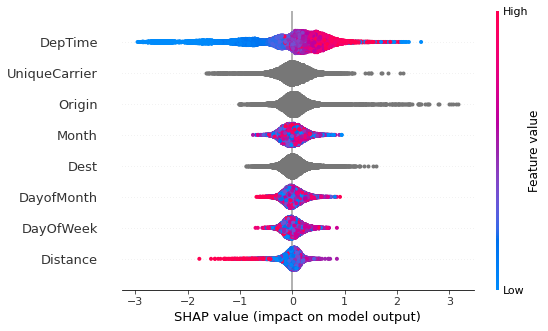

In [215]:
shap.summary_plot(shap_values, X_test_cb)

По Feature_importance и по SHAP признак DepTime (время отправления) оказался самым значимым. Интерпретация может быть приведена следующая : более ранние рейсы снижают вероятность задержки, и более поздние -- наоборот. Хоть и аэропорты осуществляют деятельность круглосуточно (вроде бы так везде), но воздушное пространство менее загружено ввиду того, что ранних утренних рейсов в целом меньше (можно убедиться зайдя на сайт любой авиакомпании), это снижает нагрузку на сотрудников аэропорта, снижает очереди на подзаправку, технические проверки и прочее, что ускоряет процесс подготовки самолета к вылету, следовательно, меньше вероятность задержки рейса. Переменные, связанные с авиалиниями и самими аэропортами сложно интерпретировать без доменного знания про базирование авиапарка или локальные погодные особенности. Также можно отметить, что малое расстояние между аэропортами увеличивает вероятность задержки. Интерпретация : если говорить про совсем небольшие расстояния, то мнение такое, что это может быть связано с малыми авиакомпаниями (по EDA выше видно, что авиакомпаний в США больше, чем в РФ, например), которые экономят на авиапарке, используя менее дорогие самолеты-флагманы, имеют более высокую вероятность столкнуться с техническими неполадками, или процесс их обслуживания между полетами более долгий. Есть и другая интерпретация, но без знаний о географических/погодных особенностях, это нельзя назвать истиной в последней инстанции: возможно, перелеты на малые расстояния преобладают в ряде городов (в нашем случае речь про аэропорты, конечно), где есть высокая вероятность резкого ухудшения погодных условий, что приведет к задержке вылета.